## Importing the libraries

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional

import joblib

In [ ]:
# Order of dataframe for weather data:
# 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'

## Importing and preparing the dataset

In [5]:
# TODO: Change location code to the location required to train on for LSTM time series weather forecasting
location_code = "kuala-lumpur"
hourly_dataframe = pd.read_csv(f'../../datasets/{location_code}/weather_data_hourly.csv')

In [6]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,2010-01-01 00:00:00+00:00,23.257000,98.20215,22.957000,0.0,1008.6,4.213692,109.98319
1,2010-01-01 01:00:00+00:00,24.607000,94.45848,23.657000,0.0,1009.3,3.600000,143.13002
2,2010-01-01 02:00:00+00:00,25.457000,89.25246,23.557001,0.0,1010.0,5.154415,155.22488
3,2010-01-01 03:00:00+00:00,26.357000,82.10335,23.057001,0.0,1010.2,4.680000,157.38010
4,2010-01-01 04:00:00+00:00,26.807001,80.19705,23.107000,0.2,1009.9,3.545589,156.03750


In [7]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

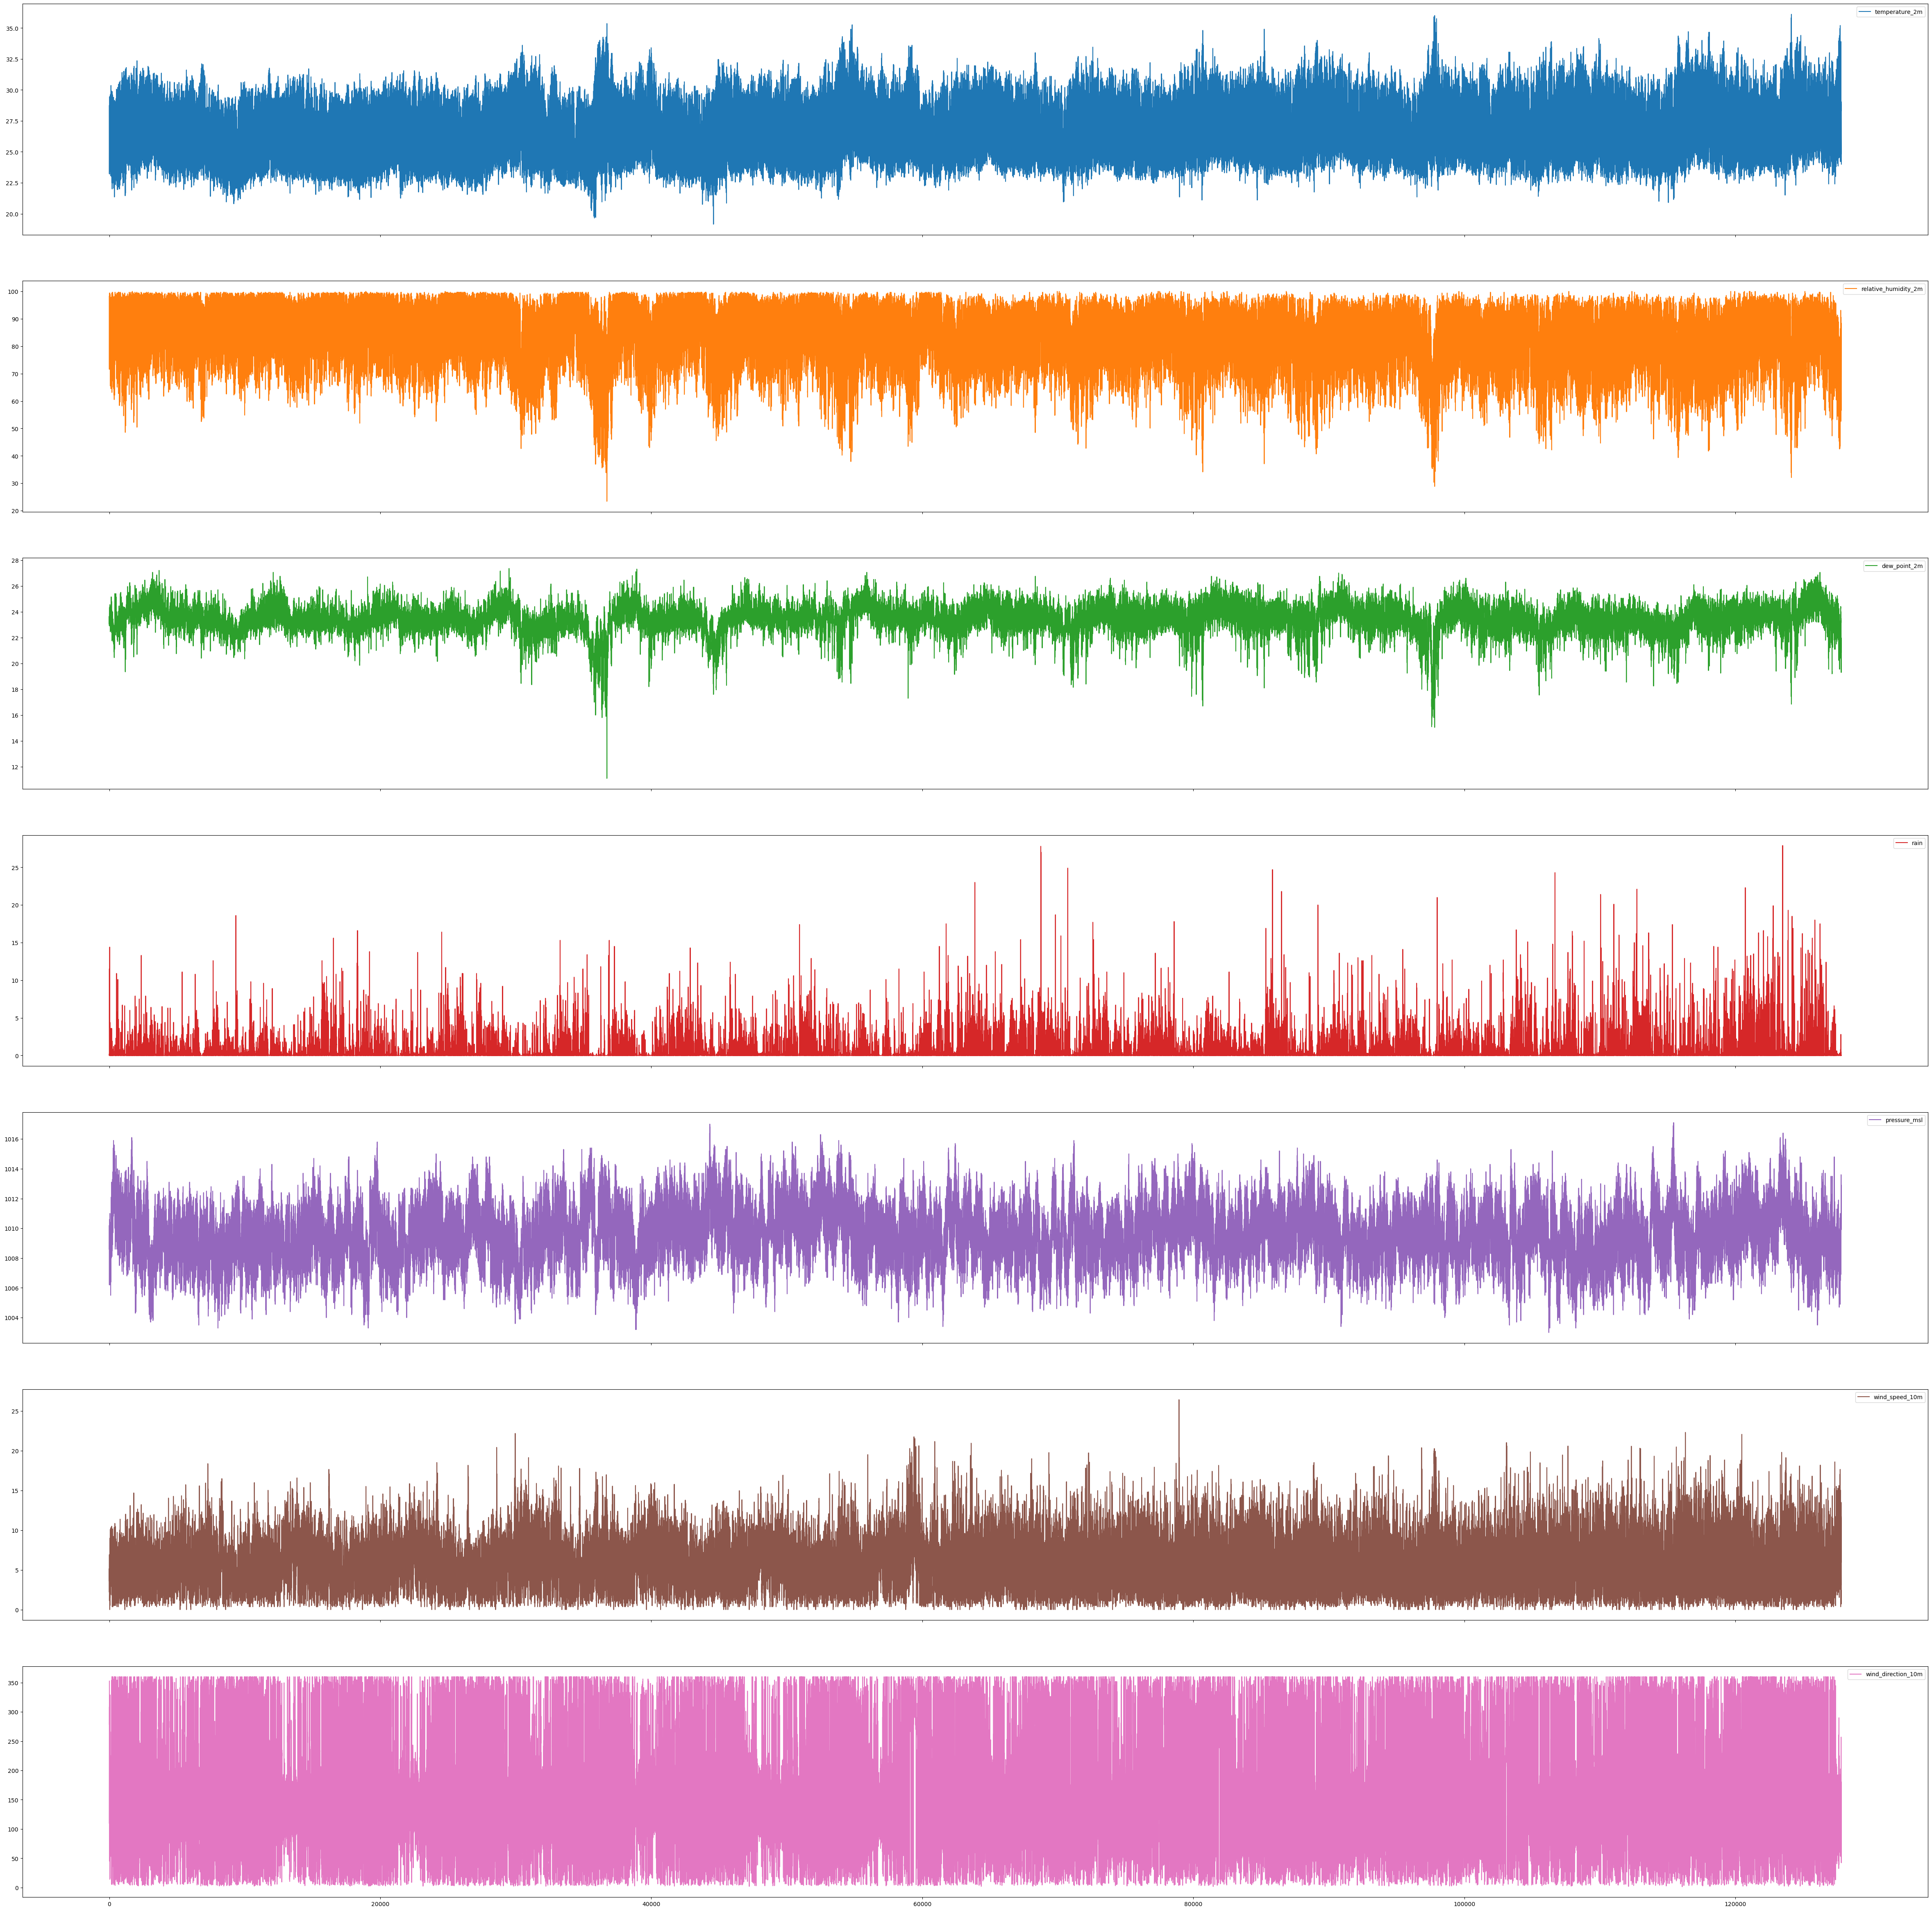

In [8]:
hourly_dataframe[['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m']].plot(subplots=True, figsize=(60, 60))

In [9]:
# Train Test split of 70-10-20 (train-eval-test) for LSTM training
training_size = int(0.70 * hourly_dataframe.shape[0])  
evaluation_size = int(0.10 * hourly_dataframe.shape[0])
testing_size = hourly_dataframe.shape[0] - training_size - evaluation_size

print("Training Size: ", training_size)
print("Evaluation Size: ", evaluation_size)
print("Testing Size: ", testing_size)
print("Total Size: ", hourly_dataframe.shape[0])

Training Size:  89476
Evaluation Size:  12782
Testing Size:  25566
Total Size:  127824


## Feature Selection Using Correlation Analysis

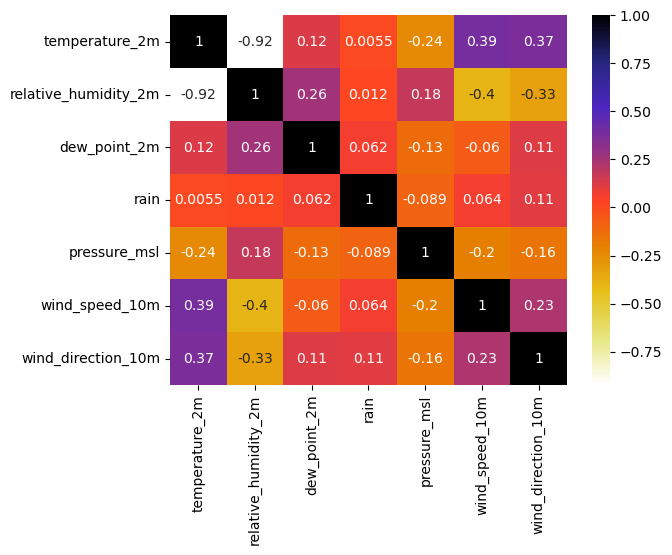

In [11]:
cor = hourly_dataframe.iloc[:training_size].drop(columns=['date']).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

## Splitting the dataset into the Training set and Test set

In [13]:
# final_hourly_dataframe = hourly_dataframe.drop(columns=['date', 'rain'])
# Set datetime as index
final_hourly_dataframe = hourly_dataframe.set_index('date')

In [15]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

In [20]:
# Splitting and preparing the train and test dataframes
# Function to convert data into sequences
def make_sequence(data, label_col, window_size =  72):

    sequences = []
    labels = []

    for i in range(data.shape[0] - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data.iloc[i+window_size])
        
    return np.array(sequences), np.array(labels)

In [21]:
training_dataset = final_hourly_dataframe.iloc[:training_size]
evaluation_dataset = final_hourly_dataframe.iloc[training_size:training_size+evaluation_size]
testing_dataset = final_hourly_dataframe.iloc[training_size+evaluation_size:]

training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
date,,,,,,,
2010-01-01 00:00:00+00:00,23.257000,98.20215,22.957000,0.0,1008.6,4.213692,109.98319
2010-01-01 01:00:00+00:00,24.607000,94.45848,23.657000,0.0,1009.3,3.600000,143.13002
2010-01-01 02:00:00+00:00,25.457000,89.25246,23.557001,0.0,1010.0,5.154415,155.22488
2010-01-01 03:00:00+00:00,26.357000,82.10335,23.057001,0.0,1010.2,4.680000,157.38010
2010-01-01 04:00:00+00:00,26.807001,80.19705,23.107000,0.2,1009.9,3.545589,156.03750


## Feature Scaling

In [22]:
scaler = MinMaxScaler() # Default feature range [0, 1]

# Fit scalar to training dataset
scaled_training_dataset = pd.DataFrame(scaler.fit_transform(training_dataset), columns=training_dataset.columns)


# Scale the evaluation and testing datasets using the same training scaler
scaled_evalutation_dataset = pd.DataFrame(scaler.transform(evaluation_dataset), columns=evaluation_dataset.columns)
scaled_testing_dataset = pd.DataFrame(scaler.transform(testing_dataset), columns=testing_dataset.columns)


scaled_training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,0.253086,0.976523,0.729231,0.000000,0.391304,0.159443,0.302039
1,0.336420,0.927637,0.772308,0.000000,0.442029,0.136222,0.394573
2,0.388889,0.859655,0.766154,0.000000,0.492754,0.195040,0.428338
3,0.444444,0.766299,0.735385,0.000000,0.507246,0.177088,0.434355
4,0.472222,0.741406,0.738462,0.007194,0.485507,0.134163,0.430607


In [23]:

# Create sequences for LSTM model for each type of dataset
X_train, y_train = make_sequence(scaled_training_dataset, 'temperature_2m')
X_eval, y_eval = make_sequence(scaled_evalutation_dataset, 'temperature_2m')
X_test, y_test = make_sequence(scaled_testing_dataset, 'temperature_2m')

In [28]:
# Print shapes of training
# Shape for X: (samples, time_steps, features)
# Shape for y: (samples, features)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_eval shape: ", X_eval.shape)
print("y_eval shape: ", y_eval.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (89404, 72, 7)
y_train shape:  (89404, 7)
X_eval shape:  (12710, 72, 7)
y_eval shape:  (12710, 7)
X_test shape:  (25494, 72, 7)
y_test shape:  (25494, 7)


In [ ]:
# Number of windows from n sized array with k window size, no +1 since we want the next predicted value
# n - k

## Create Model and Train

In [38]:
def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(LSTM(7)) # Predicting 7 features
    model.compile(optimizer='adam', loss='mse')
    return model

In [39]:
model = create_model((X_train.shape[1], X_train.shape[2]))

In [40]:
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_eval, y_eval), shuffle=False)

Epoch 1/50
1397/1397 [==============================] - 102s 66ms/step - loss: 0.0153 - val_loss: 0.0103
Epoch 2/50
1397/1397 [==============================] - 88s 63ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 3/50
1397/1397 [==============================] - 90s 64ms/step - loss: 0.0072 - val_loss: 0.0079
Epoch 4/50
1397/1397 [==============================] - 223s 160ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 5/50
1397/1397 [==============================] - 91s 65ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 6/50
1397/1397 [==============================] - 90s 65ms/step - loss: 0.0066 - val_loss: 0.0074
Epoch 7/50
1397/1397 [==============================] - 86s 61ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 8/50
1397/1397 [==============================] - 4556s 3s/step - loss: 0.0063 - val_loss: 0.0071
Epoch 9/50
1397/1397 [==============================] - 84s 60ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 10/50
1397/1397 [==============================] - 3175

## Evaluate Model

In [41]:
test_precdictions = model.predict(X_test)

797/797 [==============================] - 12s 11ms/step


In [44]:
print(test_precdictions.shape)
print(test_precdictions[0])

array([ 0.3019761 ,  0.8647827 ,  0.6818482 , -0.00183035,  0.47159827,
        0.1455204 ,  0.29861623], dtype=float32)

In [47]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, test_precdictions)
rmse = np.sqrt(mean_squared_error(y_test, test_precdictions))

print("Test data Mean Absolute Error: ", mae)
print("Test data Root Mean Squared Error: ", rmse)


Test data Mean Absolute Error:  0.04653392318085244
Test data Root Mean Squared Error:  0.09375703520866076


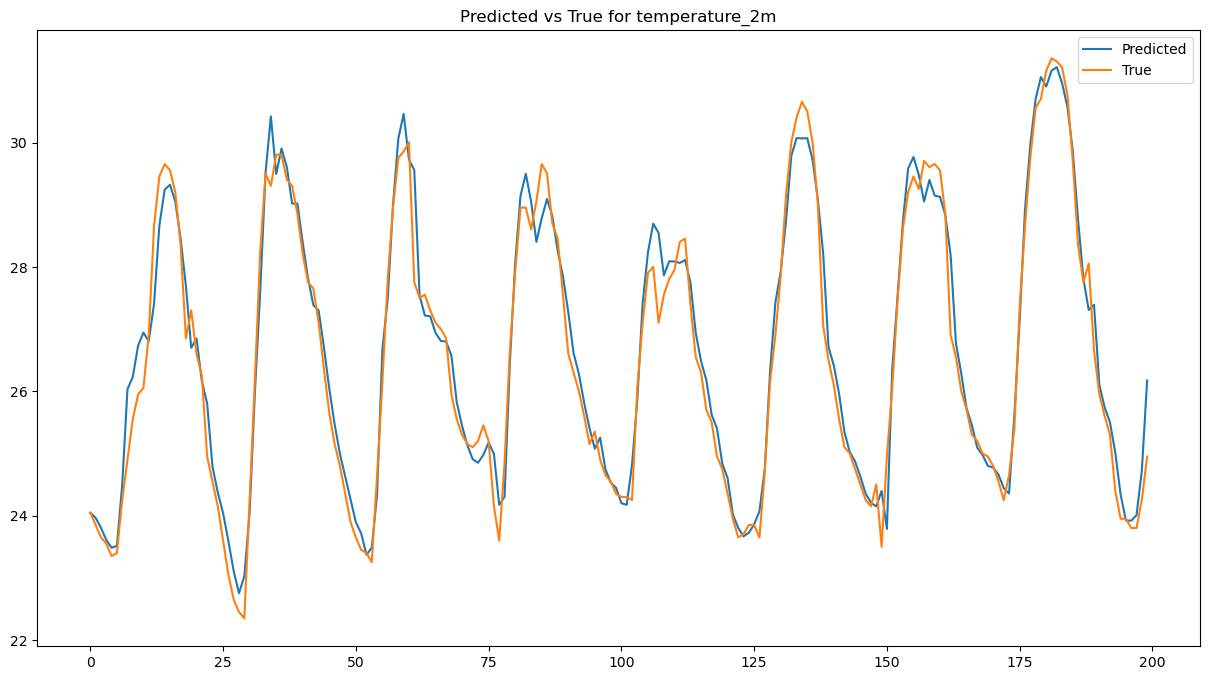

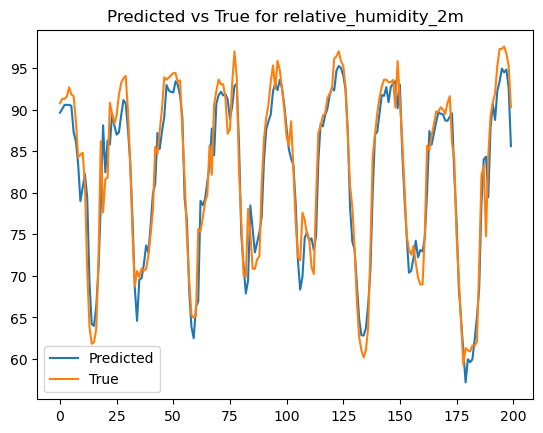

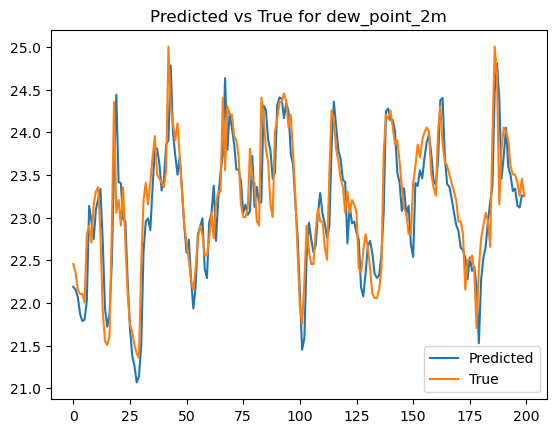

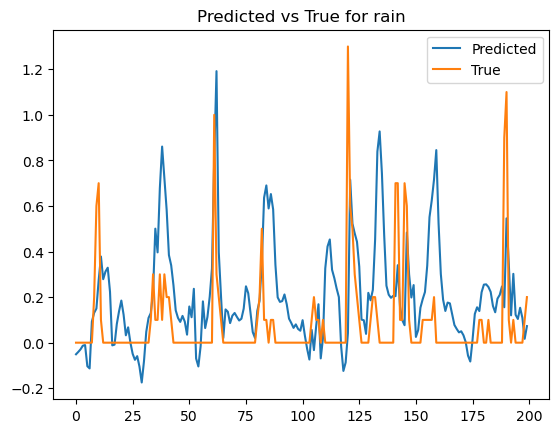

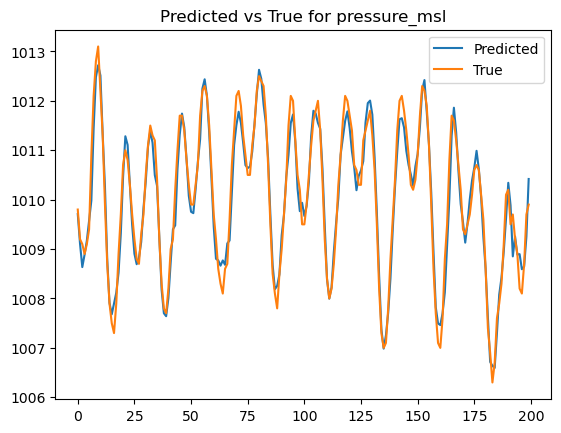

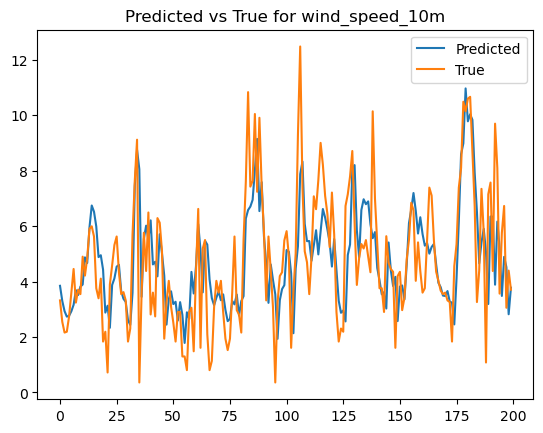

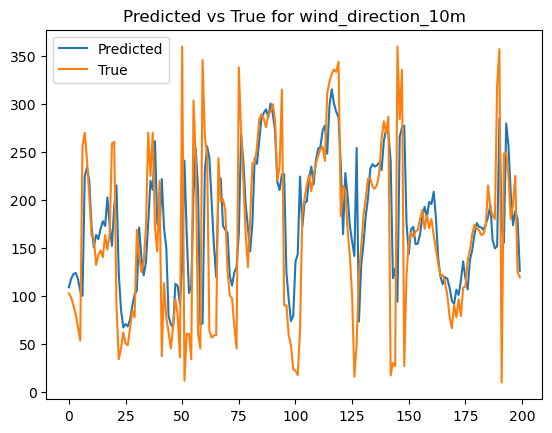

In [52]:
# Inverse transform the predictions and true values
transformed_test_predictions = scaler.inverse_transform(test_precdictions)
transformed_y_test = scaler.inverse_transform(y_test)

# Plot predicted values against true values
plt.figure(figsize=(15, 8))

# Only get the list of columns strings and exclude the first date column
columns = list(hourly_dataframe.columns)[1:]

# Plot for each attribute
for i in range(transformed_y_test.shape[1]):
    plt.plot(transformed_test_predictions[:200, i], label='Predicted')
    plt.plot(transformed_y_test[:200, i], label='True')
    plt.title(f'Predicted vs True for {columns[i]}')
    plt.legend()
    plt.show()

## Export Model and Scaler

In [65]:
model_location = f'../../models/{location_code}/model.h5'
scaler_location = f'../../models/{location_code}/scaler.pkl'


In [66]:
# Save LSTM model
model.save(model_location)

In [67]:
# Save MinMaxScaler object
joblib.dump(scaler, scaler_location)

['../../models/kuala-lumpur/scaler.pkl']